# scikit learn practice
they have a example PCA + K-means application, so i will be going throught it

In [1]:
#import iris
import xarray as xr
import matplotlib.pyplot as plt

import numpy as np
from glob import glob
import seaborn as sns
import xesmf as xe
import pandas as pd
#import def_homebrew as hb ## homemade functions xox
from scipy.special import gamma
import netCDF4 as nc
from datetime import datetime
import seaborn as sns

# ML bits
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris ## PCA practice dataset
from sklearn.datasets import load_digits ## kmeans practice dataset

import mpl_toolkits.mplot3d 

# PCA
Scikit-learn: [https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html ]
<br>
and tried example using: [https://scikit-learn.org/dev/auto_examples/decomposition/plot_pca_iris.html#sphx-glr-auto-examples-decomposition-plot-pca-iris-py ]

In [7]:
iris = load_iris(as_frame=True)
print(iris.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


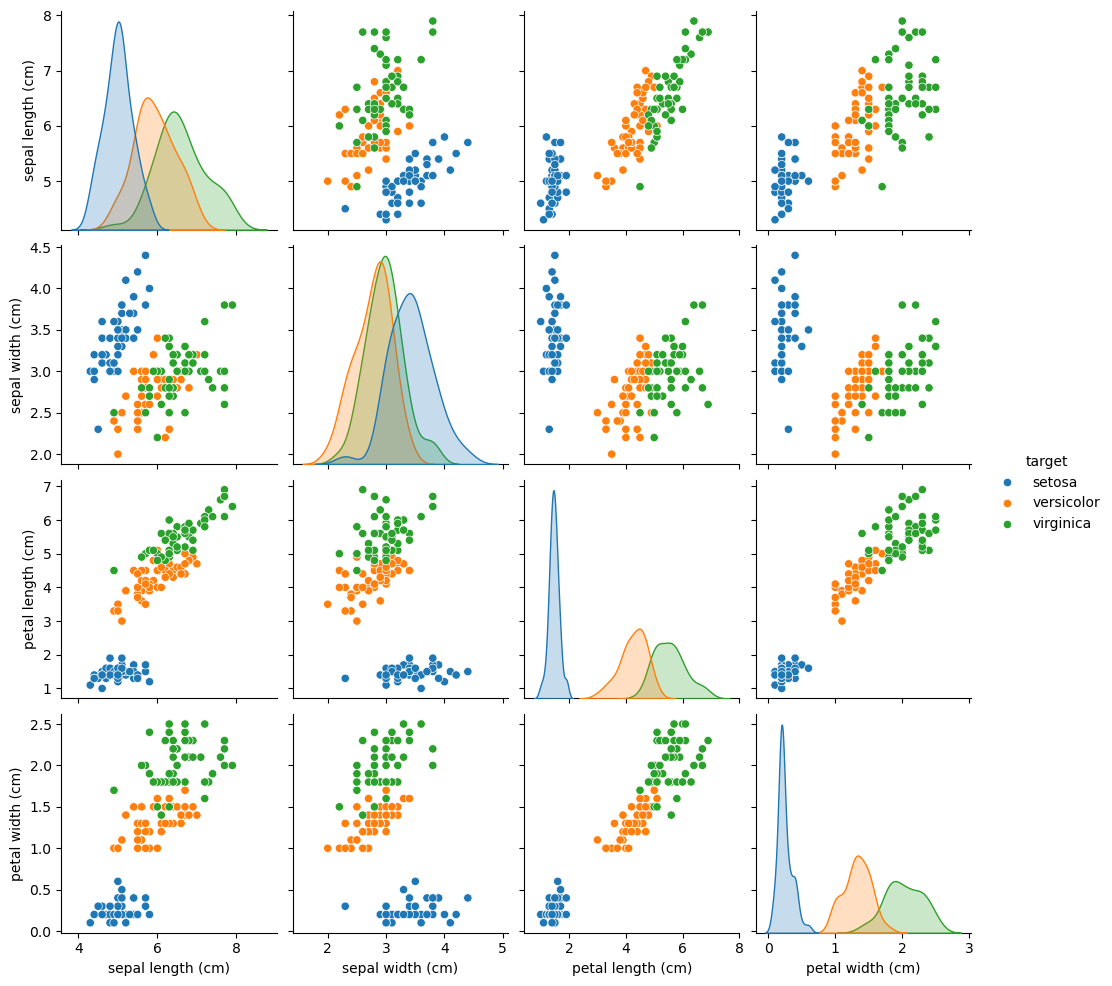

In [8]:
# Rename classes using the iris target names
iris.frame["target"] = iris.target_names[iris.target]
_ = sns.pairplot(iris.frame, hue="target")

each point on scatterplot = 1 of 150 flowers in data. each colour = species.

## PCA on data

In [11]:
X_reduced = PCA(n_components=3).fit_transform(iris.data)
# X_reduced = # array of [n , n , n] xyz coordinates for each of the 150 points

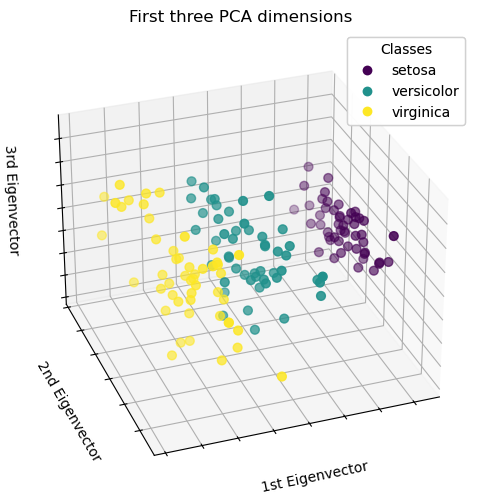

In [12]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

scatter = ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=iris.target,
    s=40,
)

ax.set(
    title="First three PCA dimensions",
    xlabel="1st Eigenvector",
    ylabel="2nd Eigenvector",
    zlabel="3rd Eigenvector",
)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

# Add a legend
legend1 = ax.legend(
    scatter.legend_elements()[0],
    iris.target_names.tolist(),
    loc="upper right",
    title="Classes",
)
ax.add_artist(legend1)

plt.show()

# K-means
Scikit-learn: [https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html ]
<br>
run through:
[https://scikit-learn.org/1.5/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py ]
<br>
<br>
K-means = seperate samples into n groups of equal variance. this algorithm = must specify number of clusters. scales well to large number samples.
<br>
algorithm divide set of $N$ samples $X$ -> $K$ disjointed clusters $C$. Each described by mean $\mu_j$ of samples in the cluster. Mean commonly described as cluster 'centroids'.
<br>
K-means aims to choose centroids that minimise inertial / within-cluster sum-of-squares criterion.
$$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)$$
Inertia = measure of how internally coherent clusters are. but with drawbacks:
* make assumption clusters are convex + isotropic. not always the case - poor job with elongated clusters / manifolds / irregular shapes
* interia is not a normalised metric - just lower values = better, 0 = best. v high dimensional space, Euclidean distances -> inflated. using PCA ahead of clustering - pos alleviate this problem + speed up computations

In [2]:
data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


this data is handwritten letters. importantly, ground truth is known for the letters.

<br>
### define evaluation benchmark
compare different initilisation methods for Kmeans. This will:
* make pipeline: scale data using StandardScaler
* train + time pipeline fitting
* measure performance of clustering viaa different metrics

In [3]:
from time import time

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

### run benchmark
this will compare 3 approaches
* `k-means++`initilisation. stochastic method + run initilisation 4 times
    *  smart technique for choosing inital cluster centres in k-means.
    *  work: spreading out initial centres to improve convergence + avoid poor clustering results
    *  stochastic = random how clusters initally chosen, but guided randomness
    *  run 4 times -> 4 new inital centres + best result selected
* random initilisation. stochasic method + run initilisation 4 times
    * compleatly random selection of initial clusters
    * stochastic = random choice -> different initial clusters each time
    * run 4 times -> choose best attempt 
* PCA initilisation - using components of PCA to initilise K-means. deterministic + single initilisation
    * PCA - reduce dimensions of the data. principal components (eigenvectors corresponding to the largest eigenvalues) -> used to initalise cluster centres
    * deterministic = same result every time, as using the same inital centres every time. PCA does not involve randomness
    * as deterministic, one run only
<br>
<br>

what does this all mean?
* `k-means++` = the default option - balance efficiency + robustness
* random = poorer clustering, but simple
* PCA = useful where principal components capture most of the variance + align well with clustering structure

In [4]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.071s	69545	0.598	0.645	0.621	0.469	0.617	0.155
random   	0.035s	69735	0.681	0.723	0.701	0.574	0.698	0.195
PCA-based	0.013s	69513	0.600	0.647	0.622	0.468	0.618	0.168
__________________________________________________________________________________


clustering evaluation. This is predominantly done knowing the ground truth.
[overview of clustering in scikit-learn](https://scikit-learn.org/1.5/modules/clustering.html)
| shorthand | description | further reading |
| --- | --- | -- |
| inertia | overall how well data was clustered, lower the better. 0 = best | - |
| homo | Homogeneity score: if cluseter contains only members of a single class (pure clusters). <br> 0-1, 1 = perfect homogenity. Homogeneous clustering = all datapoint in cluster share same ground truth label |[scikit](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.homogeneity_score.html#sklearn.metrics.homogeneity_score)|
| compl | Completeness: all members of 1 class are in the same cluster. <br> 0-1, 1 = perfect completeness. Complete clustering = data points of same ground truth label not split across clusters |[scikit](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score)|
| v-meas | V-measure: mean of Homogeneity + Completeness. 0-1, 1 = perfect clustering.| [scikit](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.v_measure_score.html#sklearn.metrics.v_measure_score) |
| ARI | adjusted Rand index: measure similarity between 2 data clusterings. <br> -1 to 1, -1= worse than random, 1 = perfect cluster | [scikit](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score) |
| AMI | adjusted mutual information: evaluate agreement between 2 clusters, corrected for chance. <br> how much info is shared between clusters, adjusted for random label assignment. <br> 0-1, 1 = perfect agreement, 0 = clustering is as good as random| [scikit](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mutual_info_score.html#sklearn.metrics.mutual_info_score)|
| Silhouette | evaluate quality of a clustering result. measure: well-seperated + compact clusters are - quantifying similarity of a point within one to clustern of another. <br> -1 to 1, 1 = well clustered + far away from other clusters (ideal), 0 = point on / near boundary between clusters, -1 = data likely in wrong cluster. | [scikit](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score) |

### visualise results - PCA reduced data
with dimension reduction, data can be displayed on 2 dimensions rather than 64 (number of features). 

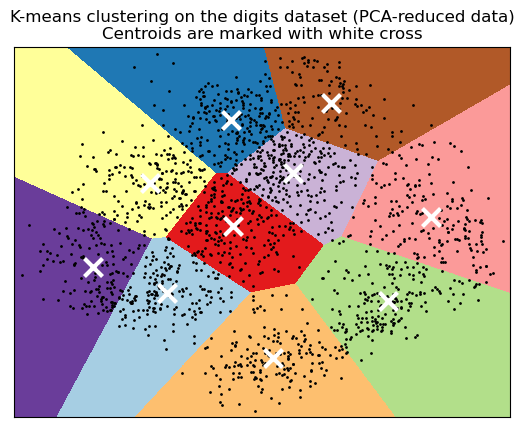

In [11]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()